In [1]:
# 1. **Imports**
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import requests
from tqdm import tqdm
import gc
import seaborn as sns
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# 2. **Dataset Download and Extraction**

# Define dataset and zip file paths
data_dir = '/kaggle/working/Plant_leave_diseases_dataset_without_augmentation'
zip_file_path = '/kaggle/working/plantvillage.zip'
# Note: Ensure that `data_url` is a direct download link to the zip file.
# The URL provided seems to be a Mendeley Data URL, which might not work directly.
# If the download fails, consider uploading the dataset to Kaggle Datasets or another accessible platform.
data_url = "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded"  # Replace with direct download link if available

def download_and_extract_dataset(data_dir, zip_file_path, data_url):
    if not os.path.exists(data_dir):
        # Step 1: Download the dataset if the zip file doesn't exist
        if not os.path.exists(zip_file_path):
            print("Downloading the dataset...")
            try:
                response = requests.get(data_url, stream=True)
                response.raise_for_status()  # Raise an exception for bad status codes

                total_size = int(response.headers.get('content-length', 0))
                block_size = 1024
                progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True, desc='Downloading')

                with open(zip_file_path, 'wb') as file:
                    for data in response.iter_content(block_size):
                        progress_bar.update(len(data))
                        file.write(data)
                progress_bar.close()
                print("\nDownload Complete")
            except requests.exceptions.RequestException as e:
                raise Exception(f"Error during download: {e}")

        # Step 2: Extract the zip file
        print("Extracting the archive...")
        try:
            shutil.unpack_archive(zip_file_path, "/kaggle/working")
        except shutil.ReadError as e:
            raise Exception(f"Extraction failed: {e}")

        # Step 3: Handle nested directories if present
        # Often, zip files contain an extra directory layer. Adjust accordingly.
        extracted_dirs = [name for name in os.listdir("/kaggle/working") 
                          if os.path.isdir(os.path.join("/kaggle/working", name)) and name != "Plant_leave_diseases_dataset_without_augmentation"]
        if extracted_dirs:
            # If there's an extra directory layer, move its contents up
            for extracted_dir in extracted_dirs:
                src_path = os.path.join("/kaggle/working", extracted_dir)
                dst_path = os.path.join("/kaggle/working", "Plant_leave_diseases_dataset_without_augmentation")
                # Move all contents from src_path to dst_path
                for item in os.listdir(src_path):
                    s = os.path.join(src_path, item)
                    d = os.path.join(dst_path, item)
                    shutil.move(s, d)
                # Remove the now-empty extracted_dir
                shutil.rmtree(src_path)
        print("Dataset Downloaded and Unzipped")
    else:
        print("Dataset already exists. Skipping download and extraction.")

# Execute dataset download and extraction
download_and_extract_dataset(data_dir, zip_file_path, data_url)

# 3. **Set Random Seed**
random_seed = 49
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# 4. **List All Image Paths and Labels**
image_paths = []
labels = []

# Assuming each subfolder in data_dir corresponds to a class
for folder_name in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, folder_name)
    if os.path.isdir(folder_path):
        for file_name in os.listdir(folder_path):
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(folder_path, file_name))
                labels.append(folder_name)

print(f"Total images found: {len(image_paths)}")
print(f"Total classes found: {len(set(labels))}")

# Encode labels as integers
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
indices = [label_to_index[label] for label in labels]
class_names = sorted(set(labels))
num_classes = len(class_names)

# 5. **Split into Train, Validation, and Test Sets**
train_indices, temp_indices, train_labels, temp_labels = train_test_split(
    list(range(len(indices))),
    indices,
    test_size=0.3,
    stratify=indices,
    random_state=random_seed
)

val_indices, test_indices, val_labels, test_labels = train_test_split(
    temp_indices,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=random_seed
)

print(f"Training samples: {len(train_indices)}")
print(f"Validation samples: {len(val_indices)}")
print(f"Test samples: {len(test_indices)}")

# 6. **Compute Class Weights to Handle Class Imbalance**
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}
print(f"Computed class weights: {class_weights}")

# 7. **Data Pipeline with tf.data API**

# Define Image Size and Batch Size
image_size = (128, 128)
batch_size = 32

# Define Data Augmentation Layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomBrightness(0.1),
    # Add more augmentations if needed
])

# Preprocessing Function
def preprocess_image(image_path, label, augment=False):
    # Read the image from disk
    image = tf.io.read_file(image_path)
    # Decode the image (handles JPEG and PNG formats)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, image_size)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    
    if augment:
        image = data_augmentation(image)
    
    return image, tf.one_hot(label, depth=num_classes)

# Create TensorFlow Datasets
def create_tf_dataset(image_paths, labels, augment=False, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=1000, seed=random_seed)
    dataset = dataset.map(lambda x, y: preprocess_image(x, y, augment), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Prepare datasets
train_dataset = create_tf_dataset([image_paths[i] for i in train_indices],
                                  [indices[i] for i in train_indices],
                                  augment=True,
                                  shuffle=True)

val_dataset = create_tf_dataset([image_paths[i] for i in val_indices],
                                [indices[i] for i in val_indices],
                                augment=False,
                                shuffle=False)

test_dataset = create_tf_dataset([image_paths[i] for i in test_indices],
                                 [indices[i] for i in test_indices],
                                 augment=False,
                                 shuffle=False)


Downloading: 100%|██████████| 868M/868M [00:49<00:00, 17.7MiB/s]  



Download Complete
Extracting the archive...
Dataset Downloaded and Unzipped
Total images found: 55448
Total classes found: 39
Training samples: 38813
Validation samples: 8317
Test samples: 8318
Computed class weights: {0: 2.256700970986685, 1: 2.2878278809313293, 2: 5.156503254948851, 3: 0.8638933404558404, 4: 1.2440064102564103, 5: 0.9469125863036424, 6: 1.3521808807134894, 7: 1.6642226224166023, 8: 2.772159131490608, 9: 1.1932915206296502, 10: 1.4423262727610553, 11: 1.224114548837796, 12: 1.2048488234928914, 13: 1.0281044712862895, 14: 1.3216535567133176, 15: 3.3621794871794872, 16: 0.2581595663307726, 17: 0.6189086618191095, 18: 3.949226699226699, 19: 1.4257953126147969, 20: 0.9615508485073703, 21: 1.4217216117216118, 22: 1.4217216117216118, 23: 9.388727624576681, 24: 3.8277120315581854, 25: 0.279316623128018, 26: 0.7750818755491653, 27: 1.282480835315887, 28: 3.1197652921790855, 29: 0.668371476296258, 30: 1.4217216117216118, 31: 0.7449140181176109, 32: 1.4943019943019944, 33: 0.8

In [6]:
# 8. **Define ResNet Model with Improved Architecture**

def residual_block(x, filters, stride=1, downsample=False):
    identity = x
    
    y = layers.Conv2D(filters, kernel_size=3, strides=stride, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)

    y = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(y)
    y = layers.BatchNormalization()(y)

    if downsample:
        identity = layers.Conv2D(filters, kernel_size=1, strides=stride, padding='same')(identity)
        identity = layers.BatchNormalization()(identity)

    out = layers.Add()([y, identity])
    out = layers.ReLU()(out)

    return out

def build_resnet(input_shape, num_classes, blocks_per_layer=[2, 2, 2, 2]):
    inputs = layers.Input(shape=input_shape)
    
    # Using smaller kernel size and stride for better spatial dimension preservation
    x = layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    # ResNet layers
    num_filters = [64, 128, 256, 512]
    for i in range(len(blocks_per_layer)):
        for j in range(blocks_per_layer[i]):
            stride = 2 if i > 0 and j == 0 else 1
            downsample = True if stride == 2 else False
            x = residual_block(x, filters=num_filters[i], stride=stride, downsample=downsample)

    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [14]:
# 9. **Build and Compile the Model**

# Instantiate the model
model = build_resnet(input_shape=(image_size[0], image_size[1], 3), 
                    num_classes=num_classes, 
                    blocks_per_layer=[2, 2, 2, 2])
model.summary()

# Define Learning Rate Schedule
steps_per_epoch = len(train_indices) // batch_size
initial_learning_rate = 0.0001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=steps_per_epoch * 1,  # Decay once every 1 epochs
    decay_rate=0.96,
    staircase=True
)

optimizer = optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 10. **Define Callbacks**

# Define the checkpoint path with the correct .keras extension
checkpoint_path = '/kaggle/working/best_model.keras'

# Define the callbacks without ReduceLROnPlateau
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1),
    TensorBoard(log_dir='/kaggle/working/logs')
]

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_80[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_68 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ re_lu_68[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 64, 64,    │     36,928 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_81[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_69 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 64, 64,    │     36,928 │ re_lu_69[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_82[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_70 (ReLU)     │ (None, 64, 64,    │          0 │ add_32[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 64, 64,    │     36,928 │ re_lu_70[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_83[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_71 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 64, 64,    │     36,928 │ re_lu_71[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_84[0][0] 

 Total params: 11,203,239 (42.74 MB)

 Trainable params: 11,193,639 (42.70 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [15]:
# 11. **Train the Model with model.fit**

epochs = 20  
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks,
    class_weight=class_weights,
    verbose=1
)

# 12. **Evaluate the Model Performance**

# Evaluate on Test Dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Generate Predictions for Classification Report and Confusion Matrix
y_true = []
y_pred = []

for images, labels_batch in test_dataset:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels_batch.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


Epoch 1/20


I0000 00:00:1734501315.147586      97 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_20', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads



1213/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.0183 - loss: 3.8095

I0000 00:00:1734501443.423486      99 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_10', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_9', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_25', 4 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_5', 4 bytes spill stores, 12 bytes spill loads




Epoch 1: val_loss improved from inf to 3.34398, saving model to /kaggle/working/best_model.keras
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 151s 112ms/step - accuracy: 0.0183 - loss: 3.8094 - val_accuracy: 0.0782 - val_loss: 3.3440
Epoch 2/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.0918 - loss: 3.3022
Epoch 2: val_loss improved from 3.34398 to 3.03851, saving model to /kaggle/working/best_model.keras
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 130s 107ms/step - accuracy: 0.0919 - loss: 3.3022 - val_accuracy: 0.1509 - val_loss: 3.0385
Epoch 3/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.1507 - loss: 3.0423
Epoch 3: val_loss improved from 3.03851 to 2.98266, saving model to /kaggle/working/best_model.keras
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 130s 107ms/step - accuracy: 0.1507 - loss: 3.0423 - val_accuracy: 0.1675 - val_loss: 2.9827
Epoch 4/20
1213/1213 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.2038 - loss: 2.8313
Epoch 4: val_loss improved from 2.98266 to 1.85583, saving mo

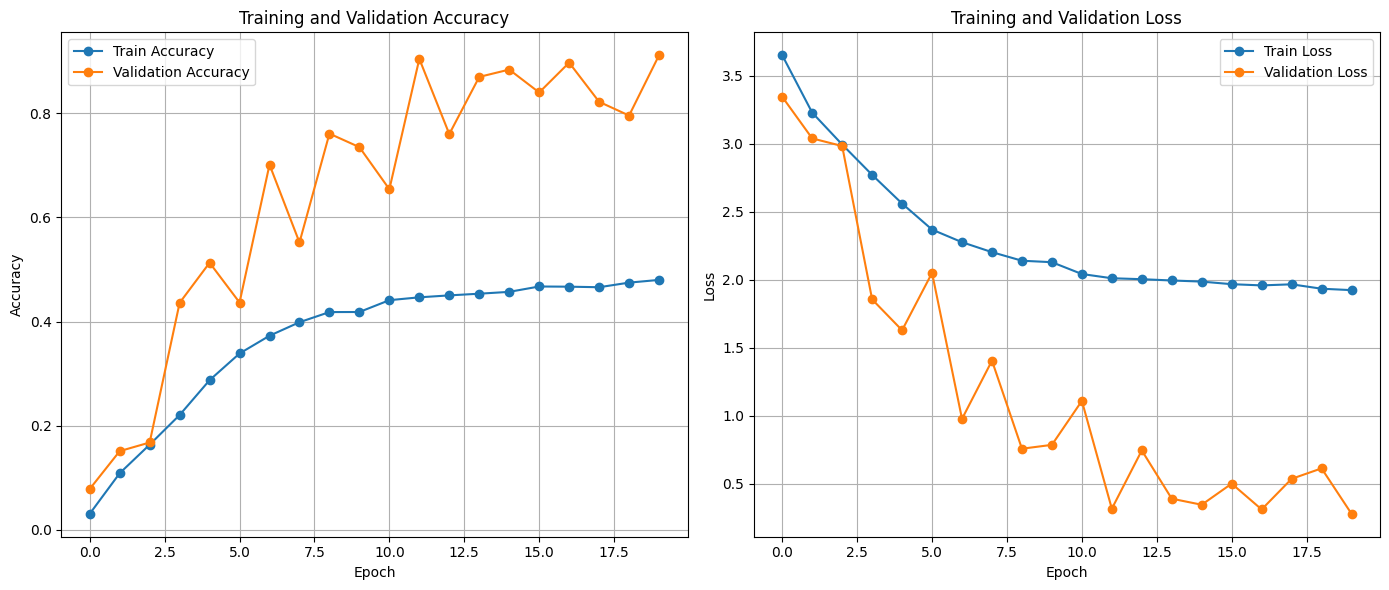

In [20]:
# Plot Training & Validation Accuracy and Loss Curves
def plot_training_history(history):
    plt.figure(figsize=(14, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', marker='o')
    plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Assuming 'history' is the variable storing training history
plot_training_history(history)

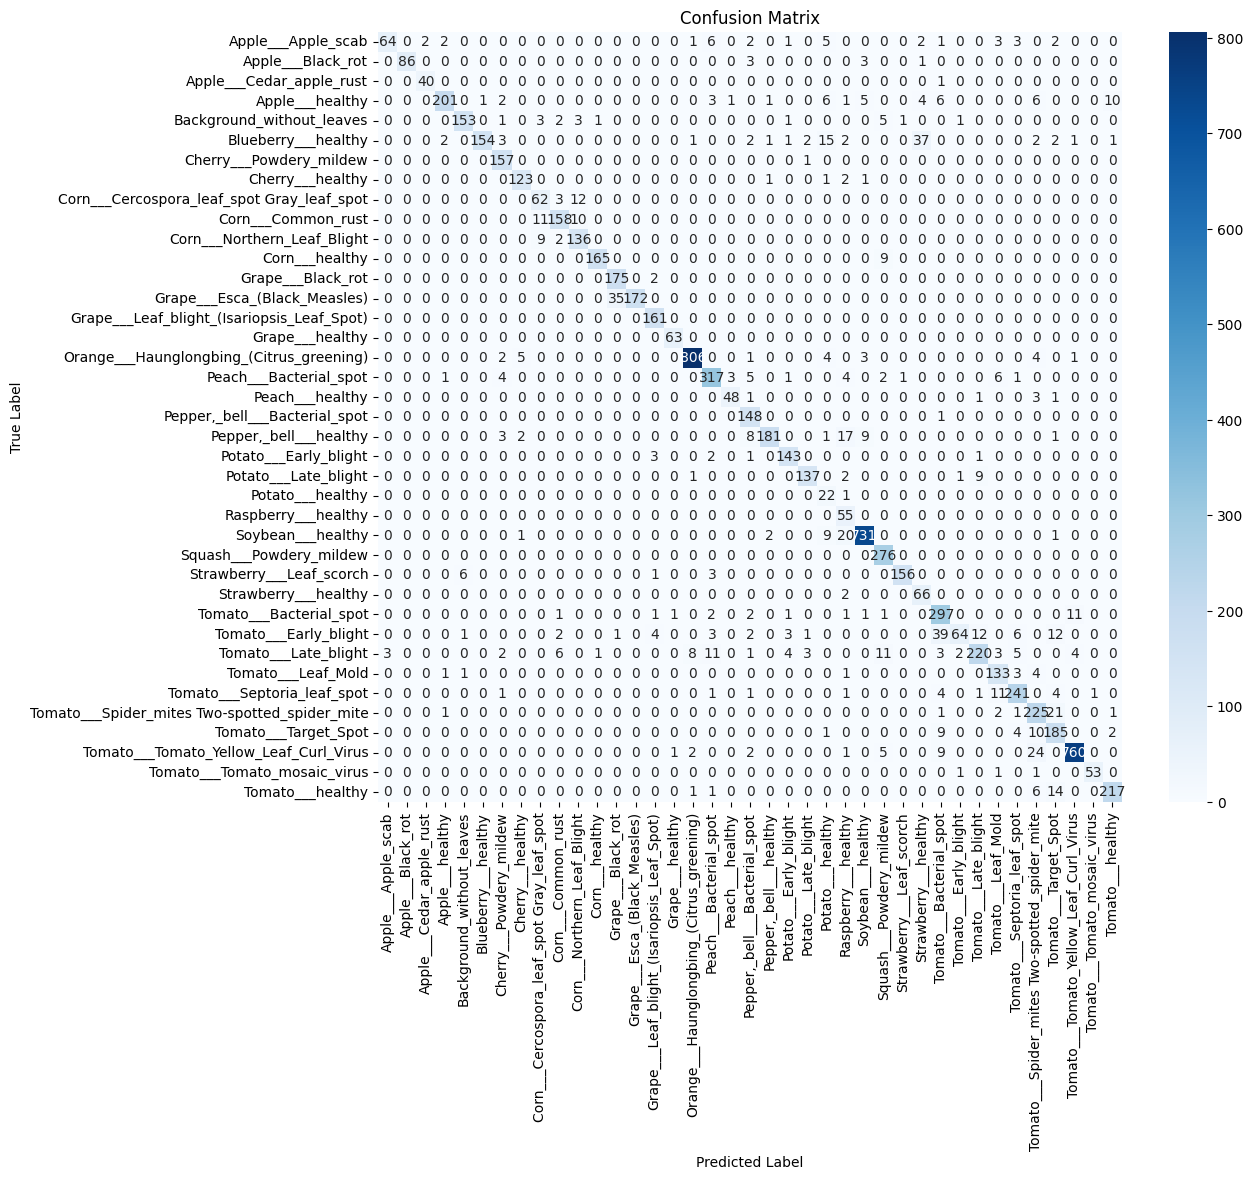

In [21]:
# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=class_names, 
                yticklabels=class_names, 
                cmap='Blues')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(cm, class_names)

In [26]:
# Binarize the output labels for ROC curves
# This converts labels to a binary format for each class
y_true_binarized = label_binarize(y_true, classes=range(num_classes))
# Number of classes
n_classes = y_true_binarized.shape[1]

In [29]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)

# Convert y_pred to class labels
y_pred = np.argmax(model.predict(test_dataset), axis=1)

# Convert y_true to correct format
y_true = np.concatenate([y.numpy() for _, y in test_dataset], axis=0)
y_true = np.argmax(y_true, axis=1)

# Binarize labels for ROC curve
y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))

for i in range(n_classes):
    # Binary labels for the current class
    binary_y_true = y_true_binarized[:, i]
    # Binary predictions for the current class
    binary_y_pred = (y_pred == i).astype(int)
    # Compute ROC curve
    fpr[i], tpr[i], _ = roc_curve(binary_y_true, binary_y_pred)
    # Compute AUC
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binarized.ravel(), label_binarize(y_pred, classes=np.arange(n_classes)).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area
# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

260/260 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


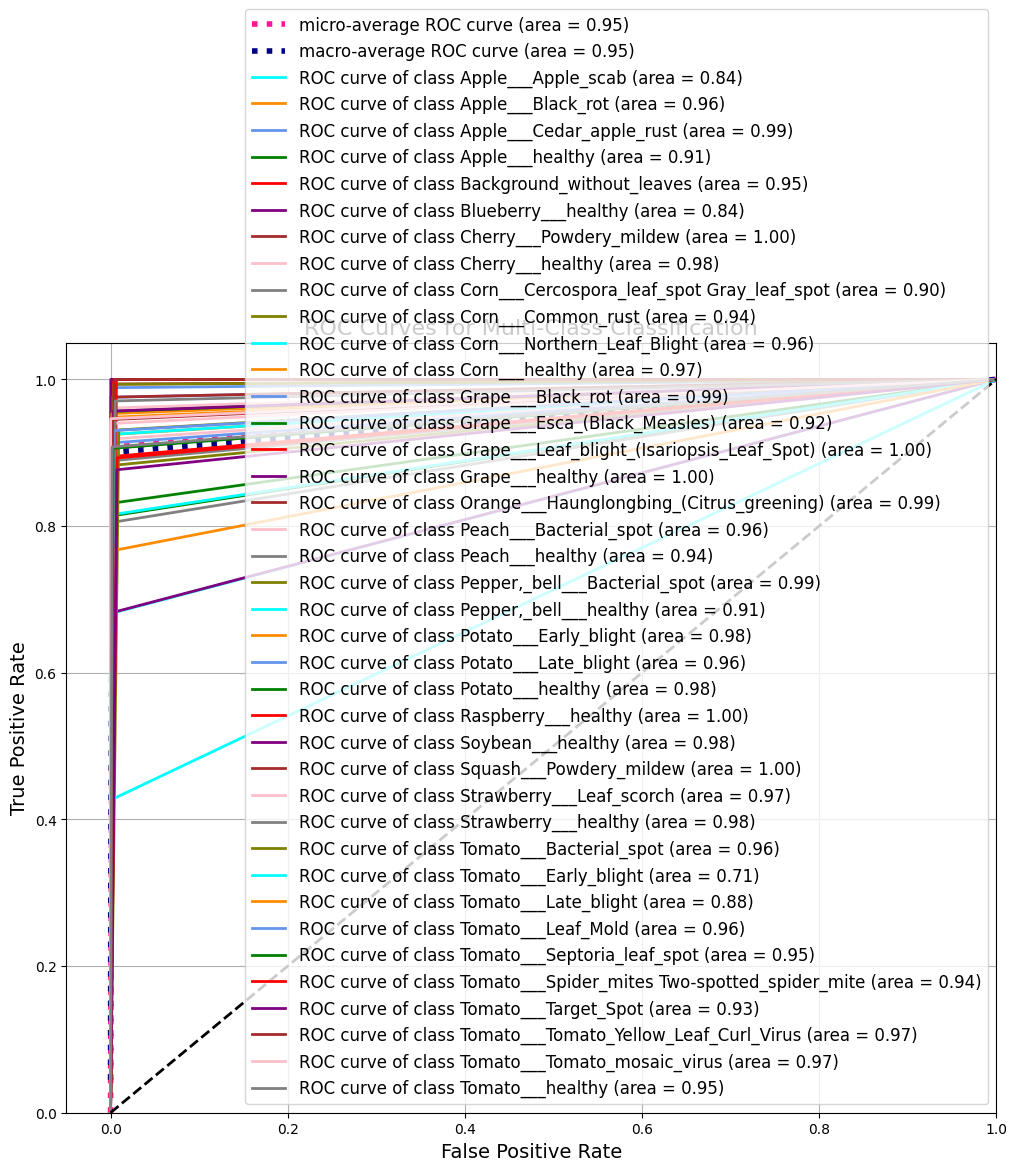

In [32]:
import matplotlib.pyplot as plt
from itertools import cycle

# Plot all ROC curves
plt.figure(figsize=(12, 10))

# Plot micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot macro-average ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

# Define color cycle for different classes
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])

# Plot ROC curve for each class
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:0.2f})')

# Plot diagonal line for random guessing
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Configure plot aesthetics
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves for Multi-Class Classification', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.show()

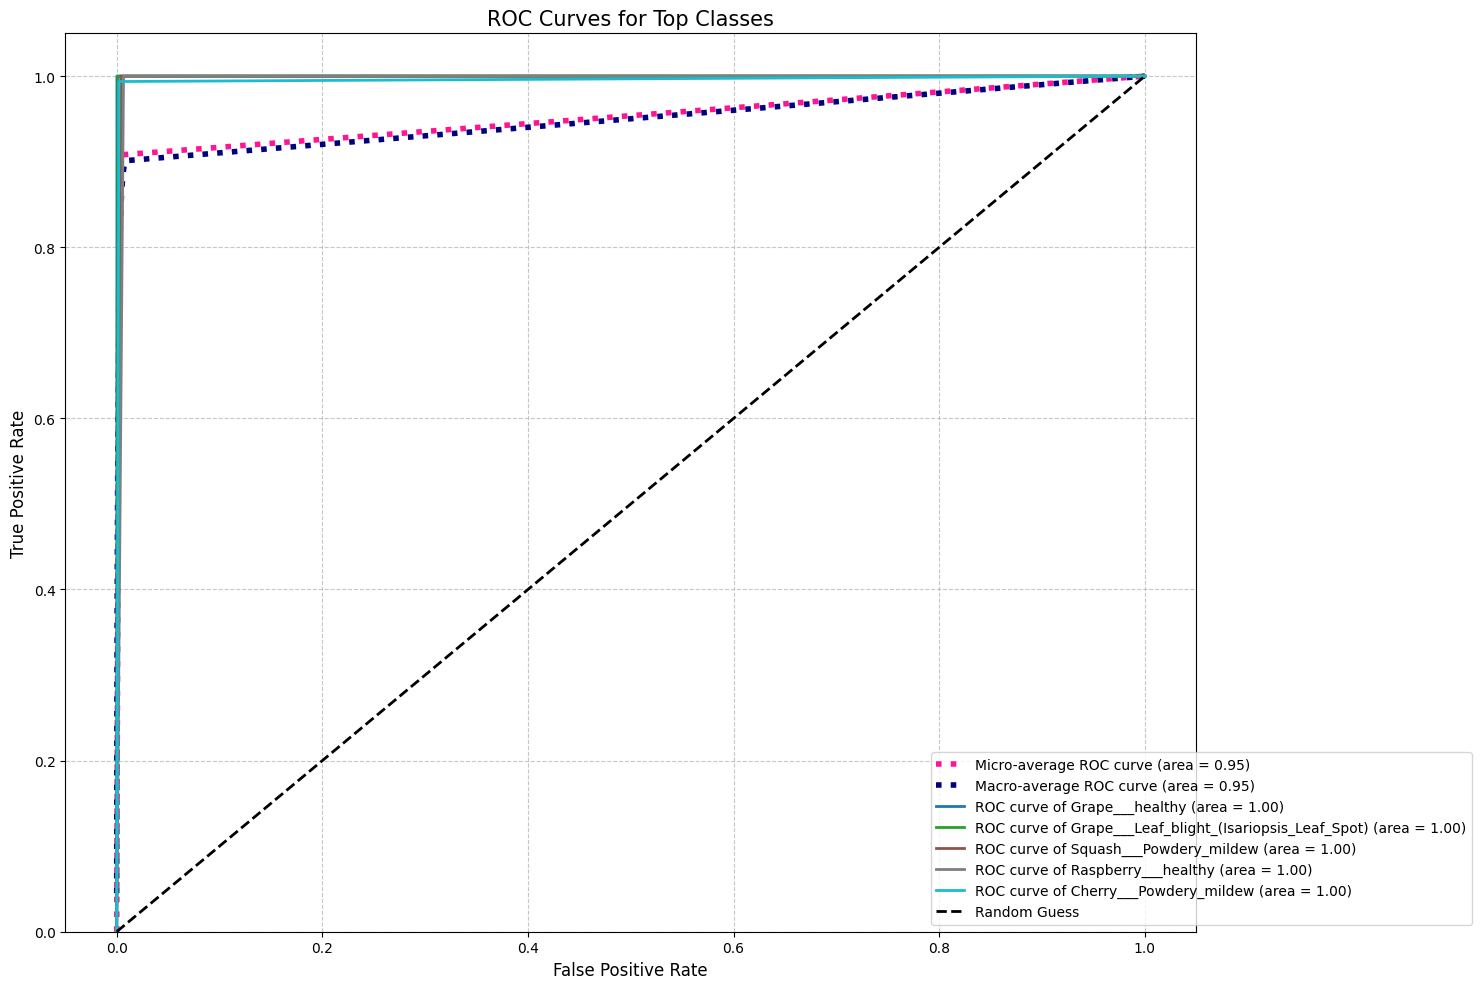

In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curves(fpr, tpr, roc_auc, n_classes, class_names, max_classes_to_show=5):
    plt.figure(figsize=(15, 10))

    # Ensure roc_auc is a dictionary or convert it
    if not isinstance(roc_auc, dict):
        roc_auc = {i: val for i, val in enumerate(roc_auc)}

    # Handle micro and macro averages
    if "micro" in roc_auc:
        plt.plot(fpr["micro"], tpr["micro"],
                 label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
                 color='deeppink', linestyle=':', linewidth=4)

    if "macro" in roc_auc:
        plt.plot(fpr["macro"], tpr["macro"],
                 label=f'Macro-average ROC curve (area = {roc_auc["macro"]:.2f})',
                 color='navy', linestyle=':', linewidth=4)

    # Determine number of classes
    if isinstance(n_classes, int):
        actual_classes = n_classes
    else:
        actual_classes = len(class_names)

    # Safety check
    if actual_classes == 0:
        print("No classes to plot!")
        return

    # Prepare color palette
    colors = plt.cm.tab10(np.linspace(0, 1, min(max_classes_to_show, actual_classes)))

    # Sort class indices by ROC AUC
    class_indices = list(range(actual_classes))
    try:
        # Remove micro and macro from sorting if present
        class_indices = [i for i in class_indices if i not in ['micro', 'macro']]
        
        # Sort indices based on ROC AUC values
        class_indices.sort(key=lambda x: roc_auc.get(x, 0), reverse=True)
    except Exception as e:
        print(f"Error sorting classes: {e}")
        # Fallback to original order if sorting fails
        class_indices = list(range(actual_classes))

    # Plot top N classes
    for i in range(min(max_classes_to_show, len(class_indices))):
        class_index = class_indices[i]
        
        # Ensure the class index exists in fpr and tpr
        if class_index in fpr and class_index in tpr:
            plt.plot(fpr[class_index], tpr[class_index], 
                     color=colors[i], 
                     lw=2,
                     label=f'ROC curve of {class_names[class_index]} (area = {roc_auc[class_index]:.2f})')

    # Add random guessing line
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guess')

    # Aesthetic improvements
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves for Top Classes', fontsize=15)
    
    # Improved legend
    plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0), fontsize=10)
    
    # Adjust layout to prevent cutting off legend
    plt.tight_layout()
    
    # Optional: Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.show()

# Usage
plot_roc_curves(fpr, tpr, roc_auc, n_classes, class_names, max_classes_to_show=5)

In [30]:
# Print AUC scores for each class
print("ROC AUC Scores for Each Class:\n")
for i in range(n_classes):
    print(f"Class {class_names[i]}: AUC = {roc_auc[i]:0.4f}")
print(f"\nMicro-average AUC: {roc_auc['micro']:0.4f}")
print(f"Macro-average AUC: {roc_auc['macro']:0.4f}")

ROC AUC Scores for Each Class:

Class Apple___Apple_scab: AUC = 0.8402
Class Apple___Black_rot: AUC = 0.9624
Class Apple___Cedar_apple_rust: AUC = 0.9877
Class Apple___healthy: AUC = 0.9064
Class Background_without_leaves: AUC = 0.9469
Class Blueberry___healthy: AUC = 0.8406
Class Cherry___Powdery_mildew: AUC = 0.9957
Class Cherry___healthy: AUC = 0.9800
Class Corn___Cercospora_leaf_spot Gray_leaf_spot: AUC = 0.9012
Class Corn___Common_rust: AUC = 0.9404
Class Corn___Northern_Leaf_Blight: AUC = 0.9611
Class Corn___healthy: AUC = 0.9740
Class Grape___Black_rot: AUC = 0.9921
Class Grape___Esca_(Black_Measles): AUC = 0.9155
Class Grape___Leaf_blight_(Isariopsis_Leaf_Spot): AUC = 0.9993
Class Grape___healthy: AUC = 0.9999
Class Orange___Haunglongbing_(Citrus_greening): AUC = 0.9870
Class Peach___Bacterial_spot: AUC = 0.9574
Class Peach___healthy: AUC = 0.9442
Class Pepper,_bell___Bacterial_spot: AUC = 0.9947
Class Pepper,_bell___healthy: AUC = 0.9073
Class Potato___Early_blight: AUC = 0.97